In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import os

# Paths
u_file = '/Users/jure/PhD/coding/RICO_1hr/rico.u.nc'
v_file = '/Users/jure/PhD/coding/RICO_1hr/rico.v.nc'
w_file = '/Users/jure/PhD/coding/RICO_1hr/rico.w.nc'

# Wind output investigation

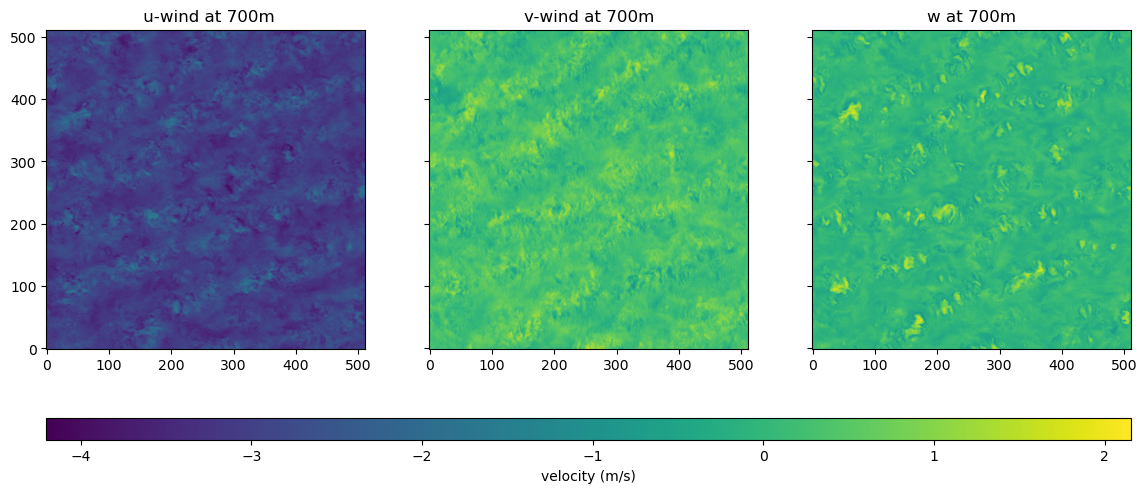

In [2]:
desired_height = 700
timestep = 10

def load_data_at_height(filename, var_name, timestep, height, vertical_dim_name):
    with nc.Dataset(filename) as ds:
        vertical_levels = ds[vertical_dim_name][:]
        idx = (np.abs(vertical_levels - height)).argmin()
        var_data = ds[var_name][timestep, idx, :, :]  # Extract 2D slice at the specified height
    return var_data

u_wind = load_data_at_height(u_file, 'u', timestep, desired_height, 'zt')
v_wind = load_data_at_height(v_file, 'v', timestep, desired_height, 'zt')
w_wind = load_data_at_height(w_file, 'w', timestep, desired_height, 'zm')

# Determine global min and max values for consistent color scaling
all_data = np.stack([u_wind, v_wind, w_wind])
vmin, vmax = all_data.min(), all_data.max()

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(14, 6), sharex=True, sharey=True)

cmap = 'viridis'
im = axs[0].imshow(u_wind, cmap=cmap, origin='lower', vmin=vmin, vmax=vmax)
axs[0].set_title(f' u-wind at {desired_height}m')

axs[1].imshow(v_wind, cmap=cmap, origin='lower', vmin=vmin, vmax=vmax)
axs[1].set_title(f'v-wind at {desired_height}m')

axs[2].imshow(w_wind, cmap=cmap, origin='lower', vmin=vmin, vmax=vmax)
axs[2].set_title(f'w at {desired_height}m')

fig.colorbar(im, ax=axs, orientation='horizontal', aspect=50, label = 'velocity (m/s)')
plt.show()



## Mean profiles of u,v wind fields for different timesteps

The plots below show that as the simulation develops the horizontal field near the surface tends to decrease. This might point to an issue in UCLA-LES forcing. 

In [3]:
def load_wind_all_levels(filename, var_name, timestep):
    with nc.Dataset(filename) as ds:
        wind_data = ds[var_name][timestep, :, :, :]  # Extract all levels for the timestep
        zt_values = ds['zt'][:]
    return wind_data, zt_values

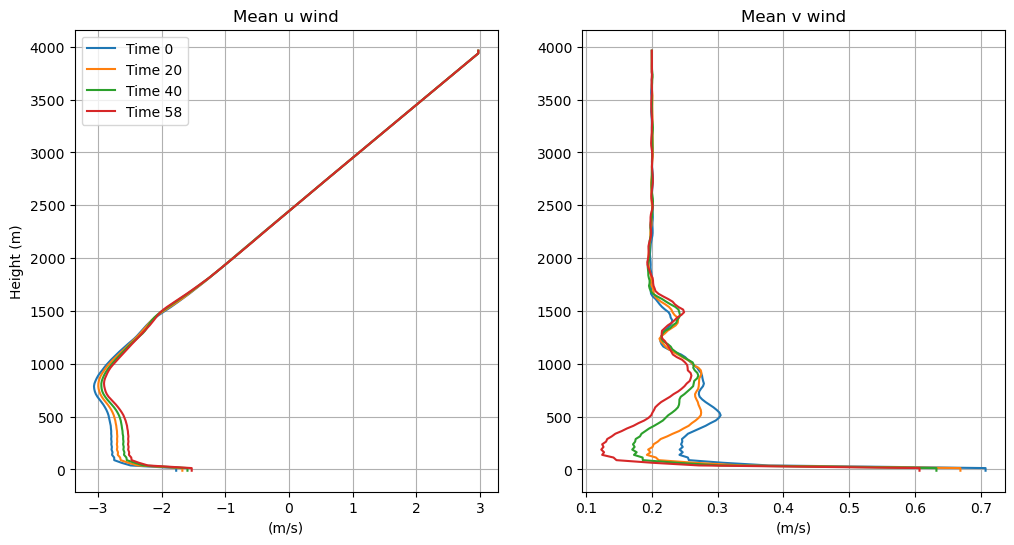

In [4]:
timesteps = [0, 20, 40, 58]

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Loop over timesteps
for timestep in timesteps:
    u_wind_data, zt_values = load_wind_all_levels(u_file, 'u', timestep)
    u_wind_means = np.mean(u_wind_data, axis=(1, 2))  # Mean over both horizontal dimensions
    axs[0].plot(u_wind_means, zt_values, label=f'Time {timestep}')
    
    v_wind_data, zt_values = load_wind_all_levels(v_file, 'v', timestep)
    v_wind_means = np.mean(v_wind_data, axis=(1, 2))
    axs[1].plot(v_wind_means, zt_values)

axs[0].set_xlabel('(m/s)')
axs[0].set_ylabel('Height (m)')
axs[0].set_title('Mean u wind')
axs[0].grid(True)
axs[0].legend()
axs[1].set_xlabel('(m/s)')
axs[1].set_title('Mean v wind')
axs[1].grid(True)
plt.savefig(os.path.join('analysis_plots', 'mean_horizontal_wind_time_variation.pdf'), format='pdf', bbox_inches='tight')

## Field mean u and v wind with variance for a given timestep
Taking the field average (for each height level). Much larger variability in v-wind. The absolute sigma variation is similar: the visual is misleading as the x-axis scale is different between the two plots. 

In [5]:
# set parameters for next few plots

timestep = 50
sigma_level = 2 # sigma level: 1 for 1σ, 2 for 2σ etc

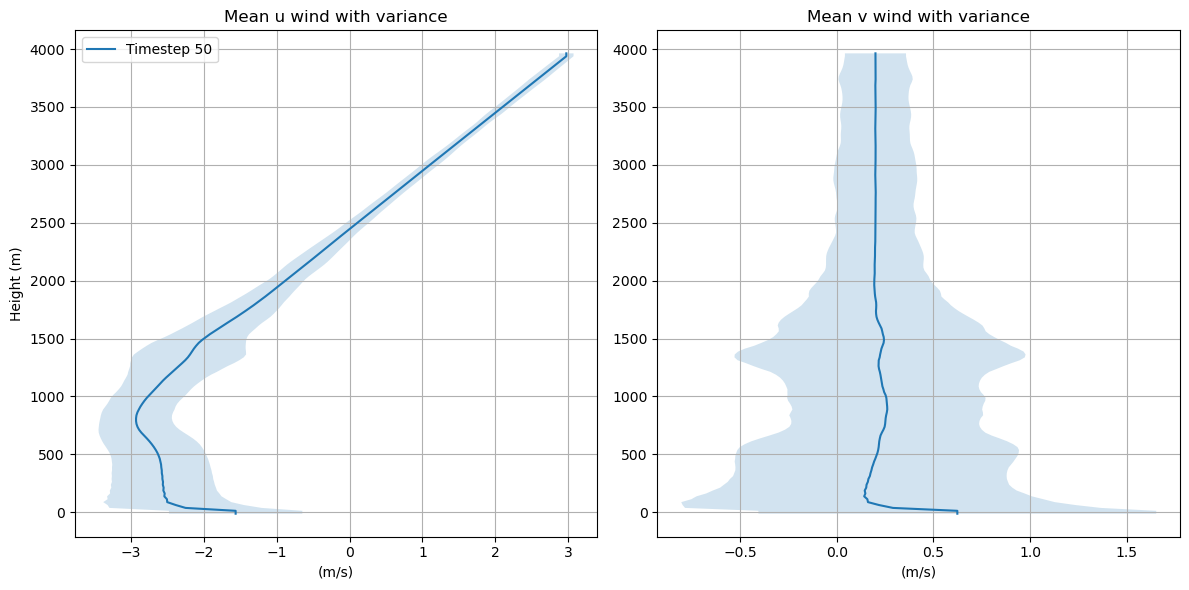

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

u_wind_data, zt_values = load_wind_all_levels(u_file, 'u', timestep)
u_wind_means = np.mean(u_wind_data, axis=(1, 2))  # Mean over both horizontal dimensions
u_wind_std = np.std(u_wind_data, axis=(1, 2))  # Standard deviation over both horizontal dimensions

v_wind_data, zt_values = load_wind_all_levels(v_file, 'v', timestep)
v_wind_means = np.mean(v_wind_data, axis=(1, 2))
v_wind_std = np.std(v_wind_data, axis=(1, 2))

axs[0].plot(u_wind_means, zt_values, label=f'Timestep {timestep}')
axs[0].fill_betweenx(zt_values, u_wind_means - sigma_level * u_wind_std, u_wind_means + sigma_level * u_wind_std, alpha=0.2)

axs[1].plot(v_wind_means, zt_values)
axs[1].fill_betweenx(zt_values, v_wind_means - sigma_level * v_wind_std, v_wind_means + sigma_level * v_wind_std, alpha=0.2)

axs[0].set_xlabel('(m/s)')
axs[0].set_ylabel('Height (m)')
axs[0].set_title('Mean u wind with variance')
axs[0].grid(True)
axs[0].legend()
axs[1].set_xlabel('(m/s)')
axs[1].set_title('Mean v wind with variance')
axs[1].grid(True)
plt.tight_layout()
plt.show()


## Comparison with cloudy part of u and v field. 

Averaging u and v fields only for liquid water points. 

In [7]:
# load liquid water field
l_dataset = nc.Dataset("/Users/jure/PhD/coding/RICO_1hr/rico.l.nc", 'r')
l_data = l_dataset.variables['l'][timestep, :, :, :]

# liquid water threshold
threshold_value = 0.0001

# Find cloudy indices
indices = np.where(l_data > threshold_value)

Sanity check to see if the clouds mask is doing the correct thing. 

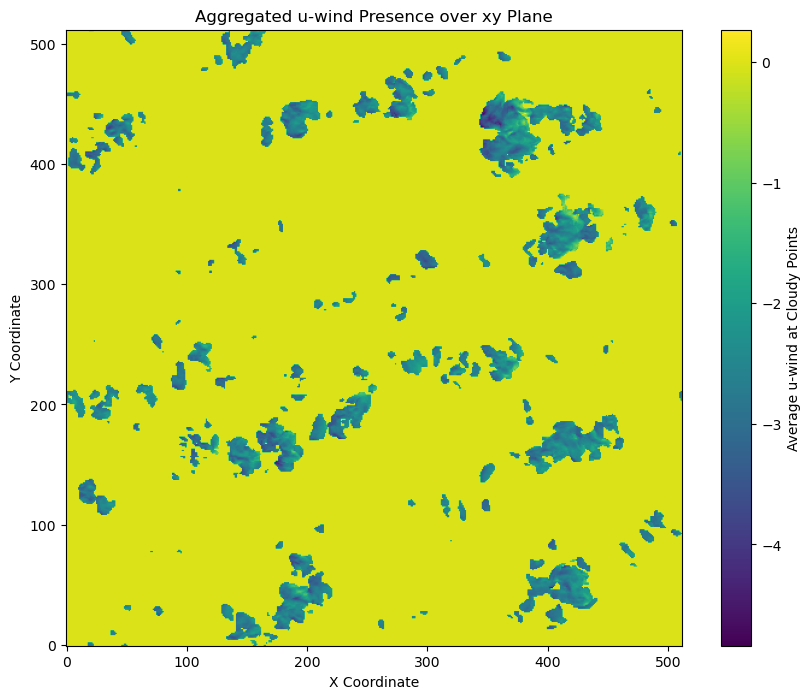

In [8]:
u_wind_at_cloudy = u_wind_data[indices]

# aggregate u-wind at cloudy points by averaging over all heights for each xy location.
u_wind_aggregated = np.zeros(l_data.shape[1:3])
count = np.zeros_like(u_wind_aggregated)

for z, y, x in zip(*indices):
    u_wind_aggregated[y, x] += u_wind_data[z, y, x]  # Summing up u-wind values
    count[y, x] += 1

# Avoid division by zero for places with no cloudy points
count[count == 0] = 1
u_wind_aggregated /= count  # Averaging

# Plotting
plt.figure(figsize=(10, 8))
plt.imshow(u_wind_aggregated, cmap='viridis', origin='lower')
plt.colorbar(label='Average u-wind at Cloudy Points')
plt.title('Aggregated u-wind Presence over xy Plane')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

Define function that calculates mean and standard deviation of wind at cloudy points at each height level to compare with field average

In [9]:
def stats_wind_cloudy_points(wind_data, cloudy_indices, zt_dim_size):
    '''calculate mean and standard deviation of wind at cloudy points at each height level'''
    mean_wind = np.zeros(zt_dim_size)
    std_wind = np.zeros(zt_dim_size)
    for i in range(zt_dim_size):
        mask = (cloudy_indices[0] == i)
        if np.any(mask):
            filtered_wind = wind_data[i, cloudy_indices[1][mask], cloudy_indices[2][mask]]
            mean_wind[i] = np.mean(filtered_wind)
            std_wind[i] = np.std(filtered_wind)
        else:
            mean_wind[i] = np.nan
            std_wind[i] = np.nan
    return mean_wind, std_wind

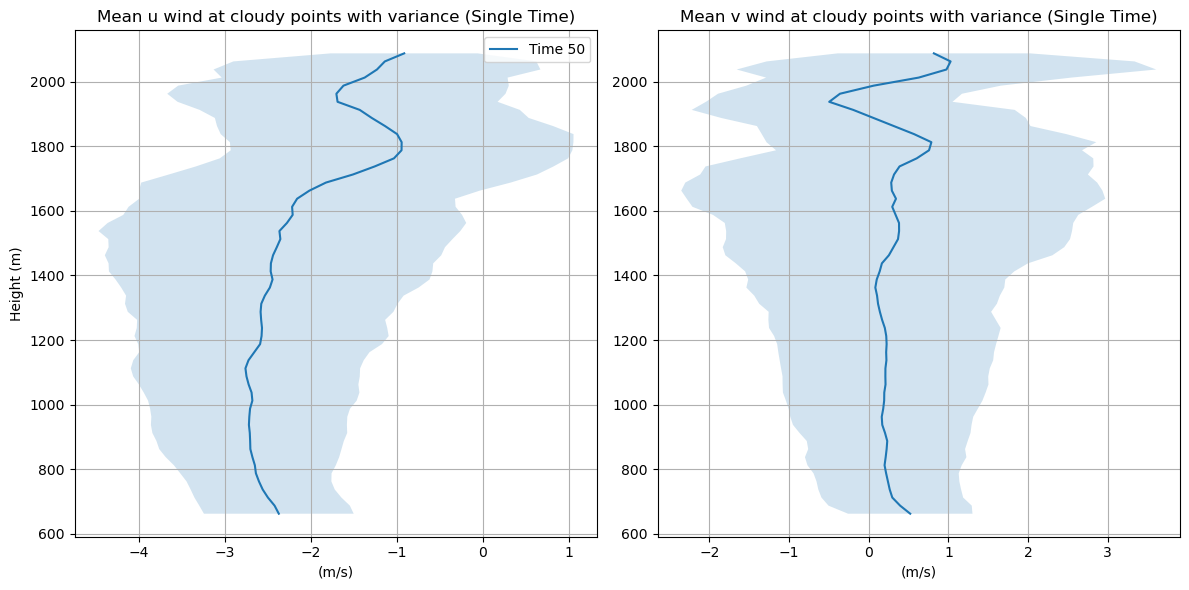

In [10]:
# Calculate mean and standard deviation for u and v wind over cloudy points
u_wind_mean_cloudy, u_wind_std_cloudy = stats_wind_cloudy_points(u_wind_data, indices, len(zt_values))
v_wind_mean_cloudy, v_wind_std_cloudy = stats_wind_cloudy_points(v_wind_data, indices, len(zt_values))

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].plot(u_wind_mean_cloudy, zt_values, label=f'Time {timestep}')
axs[0].fill_betweenx(zt_values, u_wind_mean_cloudy - sigma_level * u_wind_std_cloudy, u_wind_mean_cloudy + sigma_level * u_wind_std_cloudy, alpha=0.2)
axs[0].set_xlabel('(m/s)')
axs[0].set_ylabel('Height (m)')
axs[0].set_title('Mean u wind at cloudy points with variance (Single Time)')
axs[0].grid(True)
axs[0].legend()

axs[1].plot(v_wind_mean_cloudy, zt_values)
axs[1].fill_betweenx(zt_values, v_wind_mean_cloudy - sigma_level * v_wind_std_cloudy, v_wind_mean_cloudy + sigma_level * v_wind_std_cloudy, alpha=0.2)
axs[1].set_xlabel('(m/s)')
axs[1].set_title('Mean v wind at cloudy points with variance (Single Time)')
axs[1].grid(True)
plt.tight_layout()
plt.show()

### Compare at a given timestep

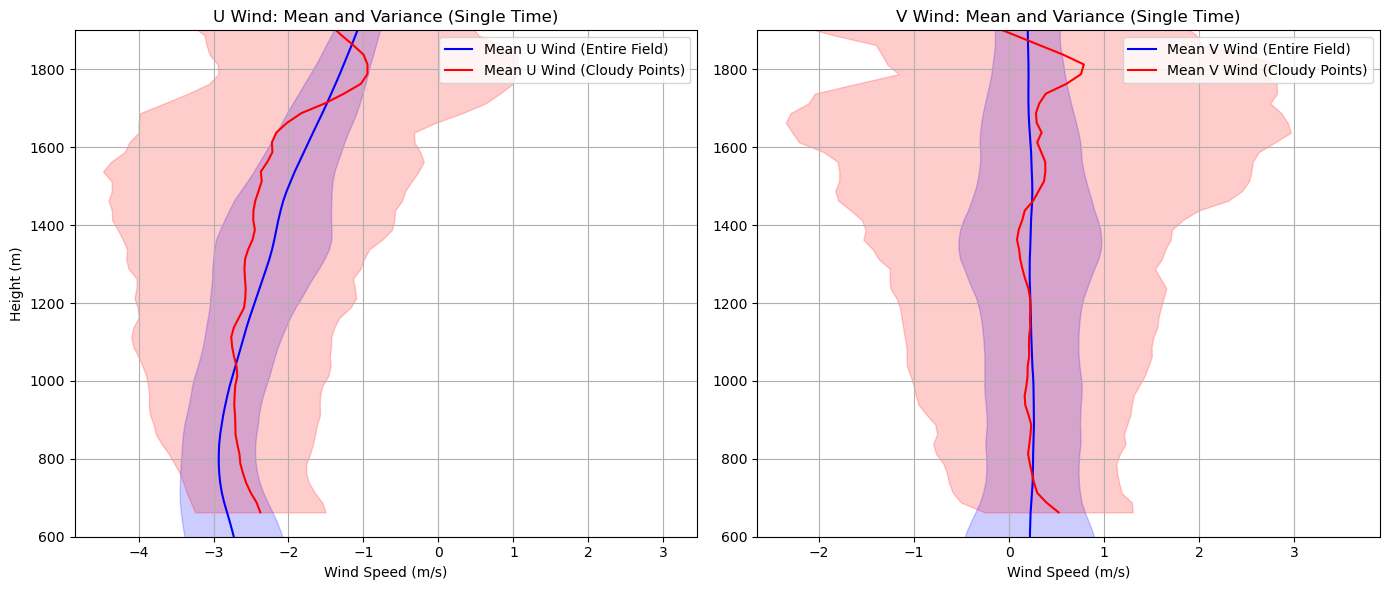

In [11]:
# Plotting
y_axis_lower_limit = 600
y_axis_upper_limit = 1900

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].plot(u_wind_means, zt_values, label='Mean U Wind (Entire Field)', color='blue')
axs[0].fill_betweenx(zt_values, u_wind_means - sigma_level * u_wind_std, 
                     u_wind_means + sigma_level * u_wind_std, alpha=0.2, color='blue')
axs[0].plot(u_wind_mean_cloudy, zt_values, label='Mean U Wind (Cloudy Points)', color='red')
axs[0].fill_betweenx(zt_values, u_wind_mean_cloudy - sigma_level * u_wind_std_cloudy, 
                     u_wind_mean_cloudy + sigma_level * u_wind_std_cloudy, alpha=0.2, color='red')
axs[0].set_ylim(y_axis_lower_limit, y_axis_upper_limit)
axs[0].set_xlabel('Wind Speed (m/s)')
axs[0].set_ylabel('Height (m)')
axs[0].set_title('U Wind: Mean and Variance (Single Time)')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(v_wind_means, zt_values, label='Mean V Wind (Entire Field)', color='blue')
axs[1].fill_betweenx(zt_values, v_wind_means - sigma_level * v_wind_std, 
                     v_wind_means + sigma_level * v_wind_std, alpha=0.2, color='blue')
axs[1].plot(v_wind_mean_cloudy, zt_values, label='Mean V Wind (Cloudy Points)', color='red')
axs[1].fill_betweenx(zt_values, v_wind_mean_cloudy - sigma_level * v_wind_std_cloudy, 
                     v_wind_mean_cloudy + sigma_level * v_wind_std_cloudy, alpha=0.2, color='red')
axs[1].set_ylim(y_axis_lower_limit, y_axis_upper_limit)
axs[1].set_xlabel('Wind Speed (m/s)')
axs[1].set_title('V Wind: Mean and Variance (Single Time)')
axs[1].legend()
axs[1].grid(True)
plt.tight_layout()
plt.savefig(os.path.join('analysis_plots', 'cloudy_vs_full_field_horizontal_wind.pdf'), format='pdf', bbox_inches='tight')


### Average over multiple timesteps

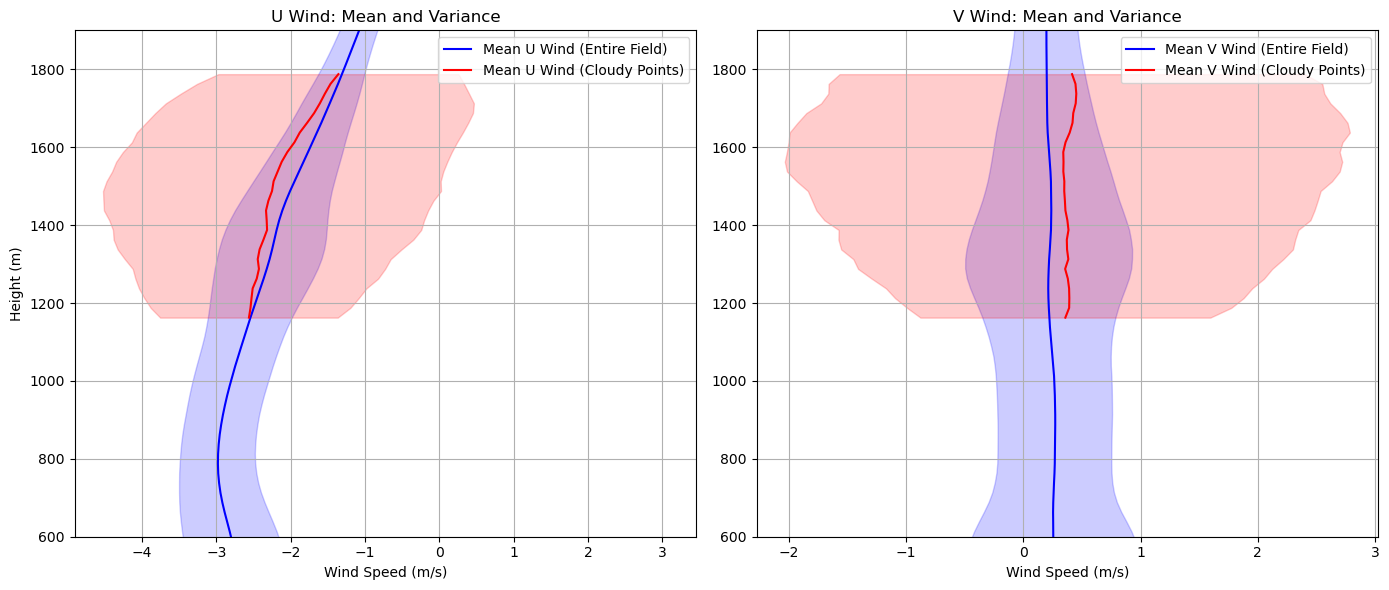

In [12]:
timesteps = list(range(10,50))

# Initialize accumulators
u_wind_mean_cloudy_accum = u_wind_std_cloudy_accum = None
v_wind_mean_cloudy_accum = v_wind_std_cloudy_accum = None
u_wind_mean_accum = u_wind_std_accum = None
v_wind_mean_accum = v_wind_std_accum = None

n_timesteps = len(timesteps)
for timestep in timesteps:
    l_dataset = nc.Dataset("/Users/jure/PhD/coding/RICO_1hr/rico.l.nc", 'r')  # Update the path accordingly
    l_data = l_dataset.variables['l'][timestep, :, :, :]
    threshold_value = 0.001
    indices = np.where(l_data > threshold_value)
    
    u_wind_data, zt_values = load_wind_all_levels(u_file, 'u', timestep)
    v_wind_data, _ = load_wind_all_levels(v_file, 'v', timestep)
    
    u_wind_mean_cloudy, u_wind_std_cloudy = stats_wind_cloudy_points(u_wind_data, indices, len(zt_values))
    v_wind_mean_cloudy, v_wind_std_cloudy = stats_wind_cloudy_points(v_wind_data, indices, len(zt_values))
    
    u_wind_means = np.mean(u_wind_data, axis=(1, 2))
    u_wind_std = np.std(u_wind_data, axis=(1, 2))
    v_wind_means = np.mean(v_wind_data, axis=(1, 2))
    v_wind_std = np.std(v_wind_data, axis=(1, 2))
    
    # Accumulate
    if u_wind_mean_cloudy_accum is None:
        # Initialize accumulators
        u_wind_mean_cloudy_accum, u_wind_std_cloudy_accum = u_wind_mean_cloudy, u_wind_std_cloudy
        v_wind_mean_cloudy_accum, v_wind_std_cloudy_accum = v_wind_mean_cloudy, v_wind_std_cloudy
        u_wind_mean_accum, u_wind_std_accum = u_wind_means, u_wind_std
        v_wind_mean_accum, v_wind_std_accum = v_wind_means, v_wind_std
    else:
        # Accumulate
        u_wind_mean_cloudy_accum += u_wind_mean_cloudy
        u_wind_std_cloudy_accum += u_wind_std_cloudy
        v_wind_mean_cloudy_accum += v_wind_mean_cloudy
        v_wind_std_cloudy_accum += v_wind_std_cloudy
        u_wind_mean_accum += u_wind_means
        u_wind_std_accum += u_wind_std
        v_wind_mean_accum += v_wind_means
        v_wind_std_accum += v_wind_std

# Calculate the overall average
u_wind_mean_cloudy_avg = u_wind_mean_cloudy_accum / n_timesteps
u_wind_std_cloudy_avg = u_wind_std_cloudy_accum / n_timesteps
v_wind_mean_cloudy_avg = v_wind_mean_cloudy_accum / n_timesteps
v_wind_std_cloudy_avg = v_wind_std_cloudy_accum / n_timesteps
u_wind_mean_avg = u_wind_mean_accum / n_timesteps
u_wind_std_avg = u_wind_std_accum / n_timesteps
v_wind_mean_avg = v_wind_mean_accum / n_timesteps
v_wind_std_avg = v_wind_std_accum / n_timesteps




# Plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# U Wind Plot
axs[0].plot(u_wind_mean_avg, zt_values, label='Mean U Wind (Entire Field)', color='blue')
axs[0].fill_betweenx(zt_values, u_wind_mean_avg - sigma_level * u_wind_std_avg, 
                     u_wind_mean_avg + sigma_level * u_wind_std_avg, alpha=0.2, color='blue')
axs[0].plot(u_wind_mean_cloudy_avg, zt_values, label='Mean U Wind (Cloudy Points)', color='red')
axs[0].fill_betweenx(zt_values, u_wind_mean_cloudy_avg - sigma_level * u_wind_std_cloudy_avg, 
                     u_wind_mean_cloudy_avg + sigma_level * u_wind_std_cloudy_avg, alpha=0.2, color='red')
axs[0].set_ylim(y_axis_lower_limit, y_axis_upper_limit)
axs[0].set_xlabel('Wind Speed (m/s)')
axs[0].set_ylabel('Height (m)')
axs[0].set_title('U Wind: Mean and Variance')
axs[0].legend()
axs[0].grid(True)

# V Wind Plot
axs[1].plot(v_wind_mean_avg, zt_values, label='Mean V Wind (Entire Field)', color='blue')
axs[1].fill_betweenx(zt_values, v_wind_mean_avg - sigma_level * v_wind_std_avg, 
                     v_wind_mean_avg + sigma_level * v_wind_std_avg, alpha=0.2, color='blue')
axs[1].plot(v_wind_mean_cloudy_avg, zt_values, label='Mean V Wind (Cloudy Points)', color='red')
axs[1].fill_betweenx(zt_values, v_wind_mean_cloudy_avg - sigma_level * v_wind_std_cloudy_avg, 
                     v_wind_mean_cloudy_avg + sigma_level * v_wind_std_cloudy_avg, alpha=0.2, color='red')
axs[1].set_ylim(y_axis_lower_limit, y_axis_upper_limit)
axs[1].set_xlabel('Wind Speed (m/s)')
axs[1].set_title('V Wind: Mean and Variance')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_92166/961648453.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  colorbar.ax.set_yticklabels(['{:.2f}'.format(x) for x in colorbar.get_ticks()])  # Format tick labels


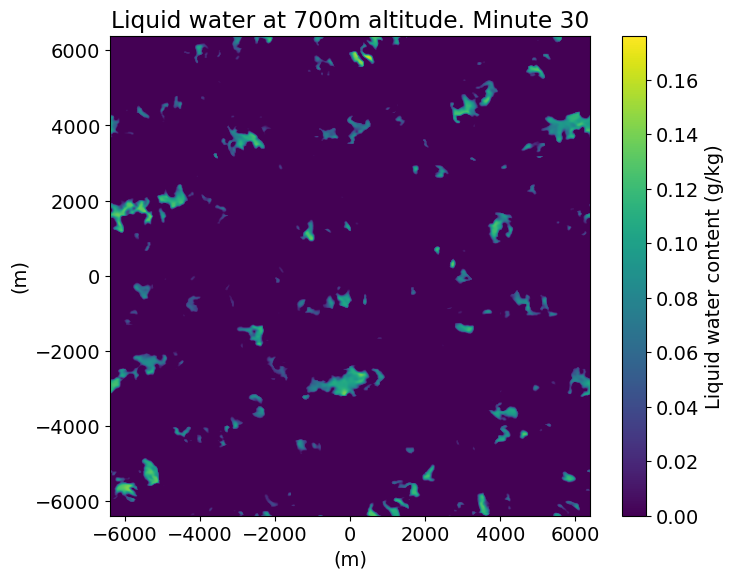

In [36]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Define the path to the liquid water content file
l_file = '/Users/jure/PhD/coding/RICO_1hr/rico.l.nc'

desired_height = 700

def load_data_at_height(filename, var_name, timestep, height, vertical_dim_name):
    with nc.Dataset(filename) as ds:
        vertical_levels = ds[vertical_dim_name][:]
        idx = (np.abs(vertical_levels - height)).argmin()
        var_data = ds[var_name][timestep, idx, :, :] * 1000  # Extract 2D slice at the specified height
        xt = ds['xt'][:]  # x-coordinates
        yt = ds['yt'][:]  # y-coordinates
    return var_data, xt, yt

def update(frame):
    ax.clear()
    l_data, xt, yt = load_data_at_height(l_file, 'l', frame, desired_height, 'zt')
    im = ax.imshow(l_data, cmap=cmap, origin='lower', vmin=vmin, vmax=vmax, extent=[xt.min(), xt.max(), yt.min(), yt.max()])
    ax.set_title(f'Liquid water at {desired_height}m altitude. Minute {frame}')  # Title added back
    ax.set_xlabel('(m)')
    ax.set_ylabel('(m)')
    return im,

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(8, 6))
cmap = 'viridis'
plt.rcParams.update({'font.size': 14})  # Increase font size by 1.5 times
fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)  # Adjust subplot edges

# Set fewer ticks on the coordinates
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.yaxis.set_major_locator(plt.MaxNLocator(5))

# Determine min and max values for color scaling across all timesteps
num_timesteps = 31  # Set the number of timesteps you want to plot
l_min = []
l_max = []
for i in range(num_timesteps):
    l_temp, _, _ = load_data_at_height(l_file, 'l', i, desired_height, 'zt')
    l_min.append(l_temp.min())
    l_max.append(l_temp.max())
vmin = min(l_min)
vmax = max(l_max)

# Create an animation
ani = FuncAnimation(fig, update, frames=num_timesteps, blit=True)

# Adjust color limits more tightly and add a colorbar
im = ax.imshow(np.zeros((10, 10)), cmap=cmap, vmin=vmin, vmax=vmax, extent=[0, 1, 0, 1])  # Dummy image for colorbar
colorbar = fig.colorbar(im, ax=ax, orientation='vertical', label='Liquid water content (g/kg)')
colorbar.ax.set_yticklabels(['{:.2f}'.format(x) for x in colorbar.get_ticks()])  # Format tick labels

# Save animation
ani.save('liquid_water_content.mp4', writer='ffmpeg', fps=1.5)

plt.show()
